<a href="https://colab.research.google.com/github/janaghoniem/Housing-Prices-Prediction-using-Machine-Learning/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediciton

In [1]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

In [5]:
dataset = pd.read_csv('/content/drive/MyDrive/Machine Learning/train.csv')

In [ ]:
dataset.head(5)

In [ ]:
dataset.tail(5)

In [ ]:
dataset.shape

In [ ]:
dataset.describe()

In [ ]:
dataset.describe(include='object')

In [ ]:
for i in dataset.select_dtypes(include= "number").columns:
  sns.histplot(data=dataset,x=i)
  plt.tight_layout()
  plt.show()

In [ ]:
for i in dataset.select_dtypes(include= "number").columns:
  sns.boxplot(data=dataset,x=i)
  plt.tight_layout()
  plt.show()

In [ ]:
numeric_columns = dataset.select_dtypes(include = "number").columns

numeric_features = [col for col in numeric_columns if col != 'SalePrice']

print(numeric_columns)

In [ ]:
for i in numeric_features:
    sns.scatterplot(data=dataset, x=i, y='SalePrice')
    plt.tight_layout()
    plt.show()

In [ ]:
dataset.info()

In [ ]:
missing_values = dataset.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values.to_frame().rename(columns={0: 'Missing Values'}))

In [ ]:
(missing_values/dataset.shape[0])*100

In [ ]:
threshold = 0.5
dataset = dataset.dropna(thresh=int(threshold * len(dataset)), axis=1)

In [ ]:
missing_values = dataset.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values.to_frame().rename(columns={0: 'Missing Values'}))

In [ ]:
(missing_values/dataset.shape[0])*100

In [ ]:
categorical_features = dataset.select_dtypes(include=['object']).columns

In [ ]:
for feature in categorical_features:
    print(f"Unique values for {feature}:")
    print(dataset[feature].unique())
    print("\n")

In [ ]:
pd.set_option('display.max_rows', None)
unique_counts = dataset.nunique()
print(unique_counts)

In [ ]:
duplicates_count = dataset.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

In [ ]:
duplicate_ids = dataset[dataset.duplicated(subset=['Id'], keep=False)]
duplicate_ids.sort_values(by='Id', inplace=True)
duplicate_ids.head(6)

In [ ]:
dataset = dataset.drop(columns=['Id'])

In [ ]:
categorical_cols = dataset.select_dtypes(include=['object']).columns
numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

In [ ]:
missing_num = [col for col in missing_values.index if col in numerical_cols]
missing_cat = [col for col in missing_values.index if col in categorical_cols]

skewness = dataset[missing_num].skew()

print("Numerical Features with Missing Values:")
print(skewness)

In [ ]:
numeric_df = dataset.select_dtypes(include=['number'])
correlation = numeric_df.corr()['LotFrontage'].sort_values(ascending=False)

print(correlation)

In [ ]:
categorical_features = dataset.select_dtypes(include=['object']).columns
anova_results = {}

for col in categorical_features:
    unique_vals = dataset[col].nunique()
    if unique_vals > 1:
        groups = [dataset['LotFrontage'][dataset[col] == category].dropna() for category in dataset[col].unique()]
        f_stat, p_value = stats.f_oneway(*groups)
        anova_results[col] = p_value

anova_results = {k: v for k, v in sorted(anova_results.items(), key=lambda item: item[1])}

print("ANOVA Test Results (Categorical vs. LotFrontage):")
print(anova_results)

In [ ]:
dataset['LotFrontage'] = dataset.groupby(['BldgType', 'Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
null_lotfrontage = dataset['LotFrontage'].isnull().sum()
print(f"Number of null values in 'LotFrontage' column: {null_lotfrontage}")

In [ ]:
dataset['MasVnrArea'].fillna(0, inplace=True)

In [ ]:
null_MasVnrArea = dataset['MasVnrArea'].isnull().sum()
print(f"Number of null values in 'MasVnrArea' column: {null_MasVnrArea}")

In [ ]:
print("Categorical Features with Missing Values:")
print(missing_cat)

In [ ]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    print(f"{col}: {dataset[col].nunique()} unique values")
    print(dataset[col].unique(), "\n")  # Display unique values

In [ ]:
print("Missing values BEFORE imputation:\n")
print(dataset[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
               'Electrical', 'FireplaceQu']].isnull().sum())

garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
has_garage = dataset[garage_cols].notnull().any(axis=1)

dataset.loc[~has_garage, garage_cols] = "NA"

for col in garage_cols:
    dataset[col] = dataset.groupby('GarageType')[col].transform(lambda x: x.fillna(x.mode()[0]))

bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
has_basement = dataset[bsmt_cols].notnull().any(axis=1)

dataset.loc[~has_basement, bsmt_cols] = "NA"

for col in bsmt_cols:
    dataset[col] = dataset.groupby('BsmtQual')[col].transform(lambda x: x.fillna(x.mode()[0]))

dataset['Electrical'].fillna(dataset['Electrical'].mode()[0], inplace=True)

dataset['FireplaceQu'].fillna("NA", inplace=True)

print("\nMissing values AFTER imputation:\n")
print(dataset[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
               'Electrical', 'FireplaceQu']].isnull().sum())

In [ ]:
print("Missing GarageYrBlt:", dataset['GarageYrBlt'].isnull().sum())
print("Rows where GarageYrBlt is missing but GarageType is NOT 'NA':")
print(dataset[dataset['GarageYrBlt'].isnull() & (dataset['GarageType'] != "NA")][['GarageType', 'GarageYrBlt', 'YearBuilt']])

In [ ]:
dataset.loc[dataset['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 0

dataset['GarageYrBlt'] = dataset['GarageYrBlt'].astype(int)

print("Missing GarageYrBlt AFTER filling:", dataset['GarageYrBlt'].isnull().sum())

In [ ]:
dataset.isnull().sum()

In [ ]:
print("Missing LotFrontage:", dataset['LotFrontage'].isnull().sum())
print(dataset[dataset['LotFrontage'].isnull()][['Neighborhood', 'BldgType', 'LotFrontage']])

In [ ]:
dataset['LotFrontage'].fillna(dataset[dataset['BldgType'] == '2fmCon']['LotFrontage'].median(), inplace=True)

In [ ]:
dataset.isnull().sum()

In [ ]:
num_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
outliers = {}
for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = ((dataset[col] < lower_bound) | (dataset[col] > upper_bound)).sum()

outliers_df = pd.DataFrame(outliers.items(), columns=['Feature', 'Outlier Count'])
print(outliers_df.sort_values(by='Outlier Count', ascending=False))

In [ ]:
# List of features to cap extreme values
cap_features = ['EnclosedPorch', 'ScreenPorch', 'OpenPorchSF', '3SsnPorch', 'WoodDeckSF',
                'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1',
                'MasVnrArea', 'Fireplaces', 'GarageArea', 'GarageCars']

for col in cap_features:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dataset[col] = np.clip(dataset[col], lower_bound, upper_bound)

In [ ]:
skewed_cols = ['LotArea', 'LotFrontage', 'SalePrice', 'GrLivArea']

# Apply log transformation
for col in skewed_cols:
    dataset[col] = np.log1p(dataset[col])  # log1p(x) = log(x + 1) to handle zeros

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cap_features[:12]):  # Show first 12 capped features
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=dataset[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
print(dataset[skewed_cols].skew().sort_values(ascending=False))

In [ ]:
num_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
outliers = {}
for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = ((dataset[col] < lower_bound) | (dataset[col] > upper_bound)).sum()

outliers_df = pd.DataFrame(outliers.items(), columns=['Feature', 'Outlier Count'])
print(outliers_df.sort_values(by='Outlier Count', ascending=False))

In [ ]:
dataset.info()

In [ ]:
duplicates_count = dataset.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

In [ ]:
#dataset.to_csv("/content/drive/My Drive/Machine Learning/cleaned_dataset.csv", index=False)

## Feature Engineering

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/Machine Learning/cleaned_dataset.csv')

In [7]:
def check_non_finite(dataset):
    non_finite_counts = (dataset.isna().sum() + (dataset == np.inf).sum() + (dataset == -np.inf).sum())
    print("Non-finite values in each column:")
    print(non_finite_counts[non_finite_counts > 0])
    dataset.info()
    return dataset

In [8]:
def replace_non_finite(dataset):
    dataset = dataset.replace([np.inf, -np.inf], np.nan)  # Convert inf/-inf to NaN first
    dataset = dataset.fillna(0)  # Replace NaN with 0
    non_finite_counts = (dataset.isna().sum() + (dataset == np.inf).sum() + (dataset == -np.inf).sum())
    print("Non-finite values in each column:")
    print(non_finite_counts[non_finite_counts > 0])
    return dataset

In [9]:
def check_duplicates(dataset):
    duplicate_count = dataset.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    return dataset

In [10]:
def display_null_counts(dataset):
    print("Number of null values per column:")
    print(dataset.isnull().sum())
    return dataset


### Creating new features

In [11]:
def create_features(dataset):
    dataset['TotalBath'] = dataset['FullBath'] + 0.5 * dataset['HalfBath'] + dataset['BsmtFullBath'] + 0.5 * dataset['BsmtHalfBath']
    dataset['TotalPorchSF'] = dataset['OpenPorchSF'] + dataset['EnclosedPorch'] + dataset['3SsnPorch'] + dataset['ScreenPorch']
    dataset['HouseAge'] = dataset['YrSold'] - dataset['YearBuilt']
    dataset['IsRemodeled'] = (dataset['YearBuilt'] != dataset['YearRemodAdd']).astype(int)
    dataset["TotalSqFt"] = dataset["GrLivArea"] + dataset["TotalBsmtSF"] + dataset["GarageArea"]
    dataset["HasGarage"] = (dataset["GarageArea"] > 0).astype(int)
    dataset["QualitySize"] = dataset["OverallQual"] * dataset["GrLivArea"]
    return dataset

### Mapping Features

In [12]:
def map_features(dataset):
    bsmt_fin_type_map = {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    dataset['BsmtFinType1'] = dataset['BsmtFinType1'].map(bsmt_fin_type_map)
    dataset['BsmtFinType2'] = dataset['BsmtFinType2'].map(bsmt_fin_type_map)

    dataset['TotalBsmtFinScore'] = (
        dataset['BsmtFinSF1'] * dataset['BsmtFinType1'] +
        dataset['BsmtFinSF2'] * dataset['BsmtFinType2']
    )

    dataset['BsmtFinRatio'] = (
        (dataset['BsmtFinSF1'] + dataset['BsmtFinSF2']) / dataset['TotalBsmtSF']
    ).fillna(0)

    nbhd_map = dataset.groupby("Neighborhood")["SalePrice"].median()
    dataset["Neighborhood"] = dataset["Neighborhood"].map(nbhd_map)
    dataset["NeighborhoodQuality"] = dataset["Neighborhood"] * dataset["OverallQual"]

    quality_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}
    for col in ["ExterQual", "KitchenQual", "HeatingQC"]:
        if col in dataset.columns:
            dataset[col + "_ordinal"] = dataset[col].map(quality_map)

    return dataset

### Drop features

In [13]:
def drop_features(dataset):
    dataset = dataset.drop(['Street'], axis=1)
    columns_to_drop = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                       'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'OverallQual',
                       'BsmtFinSF2', 'BsmtFinType2', 'BsmtFinType1', 'BsmtFinSF1',
                       'Neighborhood', 'ExterQual', 'KitchenQual', 'HeatingQC']
    dataset = dataset.drop(columns=columns_to_drop)
    return dataset

In [14]:
zero_count = (dataset['TotalBsmtSF'] == 0).sum()
print("Number of zero values in 'TotalBsmtSF':", zero_count)

Number of zero values in 'TotalBsmtSF': 0


In [15]:
dataset['BsmtFinSF2'].unique()

array([0])

### Encoding Categorical Columns

In [16]:
def encode_categorical(dataset):
    nominal_cols = [
        'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'CentralAir', 'Electrical',
        'Functional', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition'
    ]
    dataset = pd.get_dummies(dataset, columns=nominal_cols, drop_first=True)

    ordinal_cols = [
        'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC',
        'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive'
    ]

    ordinal_mappings = {
        'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
        'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
        'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
        'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
        'PavedDrive': {'Y': 2, 'P': 1, 'N': 0}
    }

    for col in ordinal_cols:
        if col in dataset.columns:
            dataset[col] = dataset[col].map(ordinal_mappings[col])

    bool_cols = dataset.select_dtypes(include=['bool']).columns
    dataset[bool_cols] = dataset[bool_cols].astype(int)

    return dataset

### Feature Scaling

In [17]:
def scale_features(dataset):
    numerical_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
    scaler = RobustScaler()
    dataset[numerical_cols] = scaler.fit_transform(dataset[numerical_cols])
    return dataset

### Saving the scaled dataset to csv file

In [18]:
def save_to_csv(dataset, filename="/content/drive/My Drive/Machine Learning/scaled_dataset.csv"):
    dataset.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

###Run Pipeline


In [19]:
def run_pipeline(dataset):
    dataset = check_non_finite(dataset)
    dataset = replace_non_finite(dataset)
    dataset = check_duplicates(dataset)
    dataset = display_null_counts(dataset)
    dataset = create_features(dataset)
    dataset = map_features(dataset)
    dataset = drop_features(dataset)
    dataset = encode_categorical(dataset)
    dataset = scale_features(dataset)
    #dataset.to_csv("scaled_dataset.csv", index=False)
    return dataset

In [20]:
dataset = run_pipeline(dataset)

Non-finite values in each column:
BsmtQual         37
BsmtCond         37
BsmtExposure     37
BsmtFinType1     37
BsmtFinType2     37
FireplaceQu     690
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-n

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 171 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(171)
memory usage: 1.9 MB


In [22]:
print(dataset.head())

   MSSubClass  LotFrontage   LotArea  OverallCond  YearBuilt  YearRemodAdd  \
0         0.2    -0.257516 -0.267660          0.0   0.652174      0.243243   
1        -0.6     0.464671  0.029682          3.0   0.065217     -0.486486   
2         0.2    -0.100761  0.399288          0.0   0.608696      0.216216   
3         0.4    -0.535329  0.017513          0.0  -1.260870     -0.648649   
4         0.2     0.634651  0.951802          0.0   0.586957      0.162162   

   MasVnrArea  ExterCond  BsmtQual  BsmtCond  ...  SaleType_ConLI  \
0    1.193303        0.0       0.0       0.0  ...             0.0   
1    0.000000        0.0       0.0       0.0  ...             0.0   
2    0.986301        0.0       0.0       0.0  ...             0.0   
3    0.000000        0.0      -1.0       1.0  ...             0.0   
4    2.130898        0.0       0.0       0.0  ...             0.0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0             0.0           0.0           0.0         

## Feature Selection

### 1.PCA/LDA + Recursive Feature Elimination
PCA is used to reduce the dimensionality of the dataset while retaining most of the variance in the data. Recursive Feature Elimination (RFE) to select the most important features. (wrapper method)

In [23]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Machine Learning/scaled_dataset.csv')

# Separate features and target
X = data.drop('SalePrice', axis=1)  # Features (all columns except 'SalePrice')
y = data['SalePrice']  # Target variable

# Step 1: Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X)  # Apply PCA to the already scaled data

print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")

# Step 2: Apply Recursive Feature Elimination (RFE)
model = LinearRegression()  # Initialize Linear Regression model
rfe = RFE(estimator=model, n_features_to_select=5)  # Select top 5 features
X_rfe = rfe.fit_transform(X_pca, y)  # Fit RFE and transform the PCA-transformed data

# Get the selected features
selected_features = rfe.support_  # Boolean mask of selected features
print(f"Selected features mask: {selected_features}")

# Step 3: Train and evaluate the model
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)  # Train the Linear Regression model
y_pred = model.predict(X_test)  # Make predictions

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Original number of features: 168
Reduced number of features after PCA: 16
Selected features mask: [False  True False False False  True False  True False False  True False
 False  True False False]
Mean Squared Error: 0.17922204116117627


### 2. Hybrid Mutual Information and Genetic Algorithm Feature Selection.
Mutual Information is a filter-based feature selection technique.
It evaluates the relevance of features independently of the model and ranks them based on their statistical relationship with the target variable.
Genetic Algorithms are wrapper-based feature selection techniques.
They evaluate feature subsets by training a model and measuring its performance ( MSE).

In [24]:
# Step 1: Generate a synthetic dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Calculate Mutual Information
mi_scores = mutual_info_regression(X_train, y_train)
mi_scores /= np.max(mi_scores)  # Normalize MI scores

# Step 3: Define the Genetic Algorithm
# Fitness function to minimize MSE
def evaluate_feature_subset(individual):
    selected_features = [i for i, val in enumerate(individual) if val == 1]
    if not selected_features:
        return (1e6,)  # Penalize empty feature subsets
    X_train_subset = X_train[:, selected_features]
    X_test_subset = X_test[:, selected_features]
    model = LinearRegression()
    model.fit(X_train_subset, y_train)
    y_pred = model.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    return (mse,)

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_feature_subset)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Adaptive parameters
def adaptive_parameters(population):
    for ind in population:
        if random.random() < 0.1:  # 10% chance to adapt
            ind.mutation_rate = min(max(ind.mutation_rate + random.uniform(-0.1, 0.1)), 0.01, 0.5)
        else:
            ind.mutation_rate = 0.05  # Default mutation rate

# Step 4: Run the Genetic Algorithm
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

population, logbook = algorithms.eaSimple(
    population, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True
)

# Step 5: Get the best feature subset
best_individual = hof[0]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print(f"Selected Features: {selected_features}")

# Step 6: Train and evaluate the model with the selected features
X_train_subset = X_train[:, selected_features]
X_test_subset = X_test[:, selected_features]
model = LinearRegression()
model.fit(X_train_subset, y_train)
y_pred = model.predict(X_test_subset)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

gen	nevals	avg    	min    
0  	50    	22086.6	6592.02
1  	27    	17227.8	2235.62
2  	26    	12355.2	5129.57
3  	23    	9170.99	5160.46
4  	28    	6963.3 	1580.62
5  	31    	5130.68	36.8609
6  	30    	4879.07	487.067
7  	25    	3610.88	478.861
8  	29    	2085.79	37.1913
9  	27    	1021.48	37.1913
10 	31    	1556.96	30.9858
11 	26    	524.954	30.9858
12 	35    	429.057	30.9249
13 	32    	495.913	30.7739
14 	31    	447.508	30.7739
15 	29    	639.938	30.7574
16 	29    	683.341	30.5099
17 	31    	806.778	30.5099
18 	26    	62.0443	0.0114002
19 	23    	357.895	0.0114002
20 	34    	911.025	0.0114002
Selected Features: [0, 1, 2, 4, 6, 10, 11, 12, 13, 15, 17, 18]
Mean Squared Error (MSE): 0.011400184009153774


### 3. Filter method + wrapper method + embdedd method
**Filter method (Mutual Information)** Selects features based on their statistical relationship with the target variable. Reduces the feature set to the top 40 features based on mutual information scores. <br><br>
**Wrapper Method (Recursive Feature Elimination - RFE) ** Selects features by recursively eliminating the least important features based on a model's performance, Reduces the feature set to the top 20 features based on recursive elimination. <br><br>
**Embedded Method (Lasso Regression)** Uses Lasso regression to select features by penalizing less important features (shrinking their coefficients to zero). Further reduces the feature set to the most important features identified by Lasso.

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Custom Transformer for Lasso Feature Selection
class LassoFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, min_features=20):
        self.min_features = min_features
        self.important_features = None

    def fit(self, X, y):
        alpha = 0.001  # Start with a small alpha
        while True:
            lasso = Lasso(alpha=alpha)
            lasso.fit(X, y)

            self.important_features = np.where(lasso.coef_ != 0)[0]
            if len(self.important_features) >= self.min_features:
                break  # Stop when we have at least `min_features`
            alpha *= 0.5  # Reduce alpha to be less aggressive in feature elimination
        return self

    def transform(self, X):
        return X[:, self.important_features]

# Load dataset
dataset_path = '/content/drive/MyDrive/Machine Learning/scaled_dataset.csv'
df = pd.read_csv(dataset_path)

X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Target

# Split data into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('filter_method', SelectKBest(score_func=mutual_info_regression, k=40)),  # Step 1: Filter Method
    ('wrapper_method', RFE(LinearRegression(), n_features_to_select=20)),      # Step 2: Wrapper Method
    ('embedded_method', LassoFeatureSelector(min_features=20)),               # Step 3: Embedded Method
    ('regressor', LinearRegression())                                        # Final Regression Model
])

# Fit the pipeline
pipeline.fit(X_train_val, y_train_val)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE after Pipeline: {mse:.4f}")

# Extract selected features from each step
filter_features = X.columns[pipeline.named_steps['filter_method'].get_support()].tolist()
wrapper_support = pipeline.named_steps['wrapper_method'].support_
wrapper_features = [filter_features[i] for i in range(len(filter_features)) if wrapper_support[i]]
embedded_features = [wrapper_features[i] for i in pipeline.named_steps['embedded_method'].important_features]

print("Filter Selected Features:", filter_features)
print("Wrapper Selected Features:", wrapper_features)
print("Embedded Selected Features:", embedded_features)
print("Final Selected Feature Count:", len(embedded_features))

MSE after Pipeline: 0.0046
Filter Selected Features: ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtQual', 'BsmtExposure', 'BsmtUnfSF', '2ndFlrSF', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars', 'SalePrice', 'TotalBath', 'HouseAge', 'TotalSqFt', 'HasGarage', 'QualitySize', 'TotalBsmtFinScore', 'BsmtFinRatio', 'NeighborhoodQuality', 'ExterQual_ordinal', 'KitchenQual_ordinal', 'HeatingQC_ordinal', 'MSZoning_FV', 'LotShape_Reg', 'LandContour_Lvl', 'LotConfig_FR2', 'Condition1_RRNn', 'Condition2_RRAe', 'Exterior1st_VinylSd', 'Exterior1st_WdShing', 'Exterior2nd_MetalSd', 'Exterior2nd_VinylSd', 'Foundation_CBlock', 'Foundation_PConc', 'Functional_Maj2', 'Functional_Min2', 'SaleType_New', 'SaleType_WD', 'SaleCondition_Normal']
Wrapper Selected Features: ['BsmtUnfSF', 'KitchenAbvGr', 'GarageCars', 'HasGarage', 'QualitySize', 'TotalBsmtFinScore', 'BsmtFinRatio', 'NeighborhoodQuality', 'MSZoning_FV', 'LotShape_Reg', 'LandContour_Lvl', 'LotConfig_FR2', 'Condition1_RRNn', 'Condition2

## Saving feature selection pipeline (method with the lowest MSE) to drive

In [27]:
import joblib

# Save the pipeline to a file
pipeline_file = '/content/drive/MyDrive/Machine Learning/Selection_pipeline.joblib'
# Save the pipeline to Google Drive
joblib.dump(pipeline, pipeline_file)
print(f"Pipeline saved to {pipeline_file}")

Pipeline saved to /content/drive/MyDrive/Machine Learning/Selection_pipeline.joblib


## Model Training and visuzalization


Model Performance on Validation Set (K-Fold CV):
Linear Regression:
  MAE: 0.0107
  MSE: 0.0015
  RMSE: 0.0333
  R2 Score: 0.9802

Polynomial Regression (Degree=2):
  MAE: 0.0518
  MSE: 0.0194
  RMSE: 0.1367
  R2 Score: 0.7340

Ridge Regression:
  MAE: 0.0130
  MSE: 0.0013
  RMSE: 0.0309
  R2 Score: 0.9826

Lasso Regression:
  MAE: 0.1527
  MSE: 0.0765
  RMSE: 0.2751
  R2 Score: -0.0082

Best Model Before Tuning: Ridge Regression


Model Performance After Tuning:
Ridge Regression (Training Set):
  MAE: 0.0100
  MSE: 0.0008
  RMSE: 0.0284
  R2 Score: 0.9895

Ridge Regression (Test Set):
  MAE: 0.0148
  MSE: 0.0046
  RMSE: 0.0681
  R2 Score: 0.9442

Best Parameters: {'alpha': 1}


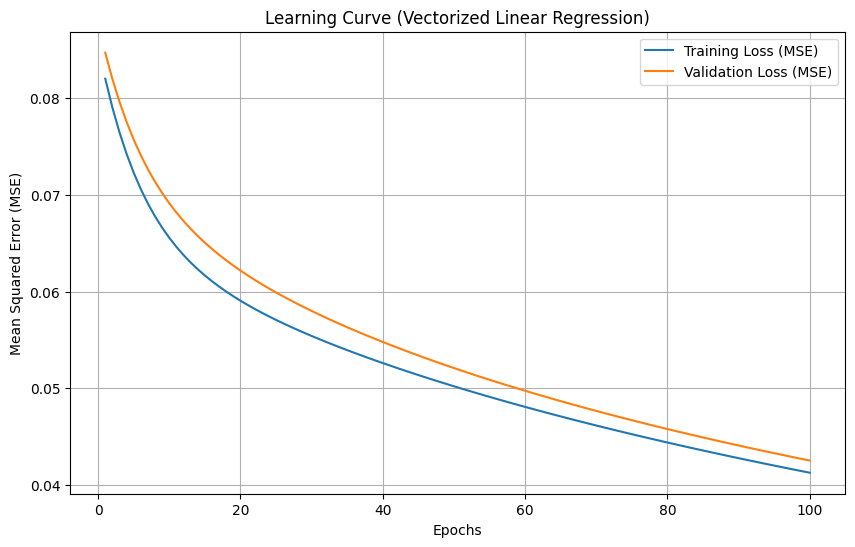

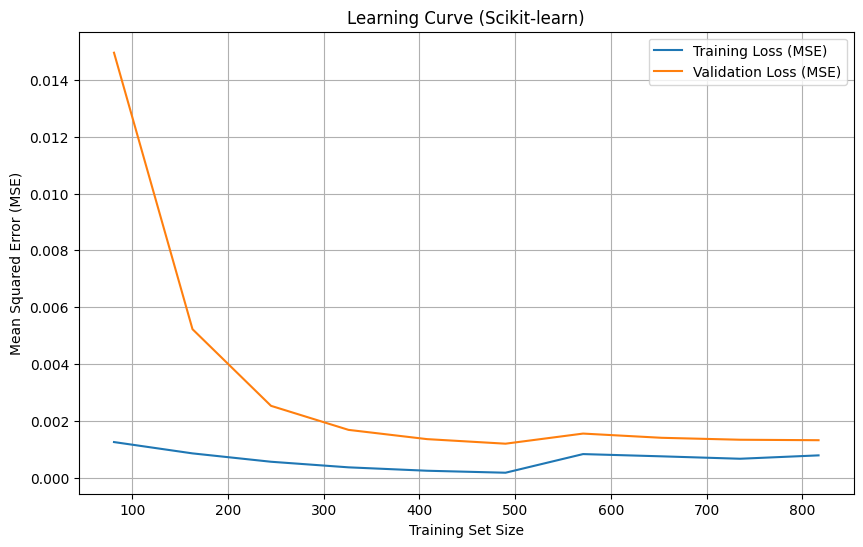

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset (selected features)
df = embedded_features

#X = df.iloc[:, :-1]  # Features
#y = df.iloc[:, -1]   # Target

#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# K-Fold Cross-Validation (Validation set is selected in each fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (Degree=2)": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

# Train and evaluate models using K-Fold Cross-Validation
results = {}
for name, model in models.items():
    mae_list, mse_list, rmse_list, r2_list = [], [], [], []

    for train_idx, val_idx in kf.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mae_list.append(mean_absolute_error(y_val, y_pred))
        mse_list.append(mean_squared_error(y_val, y_pred))
        rmse_list.append(np.sqrt(mse_list[-1]))
        r2_list.append(r2_score(y_val, y_pred))

    results[name] = (np.mean(mae_list), np.mean(mse_list), np.mean(rmse_list), np.mean(r2_list))

# Display results
print("\nModel Performance on Validation Set (K-Fold CV):")
for name, (mae, mse, rmse, r2) in results.items():
    print(f"{name}:\n  MAE: {mae:.4f}\n  MSE: {mse:.4f}\n  RMSE: {rmse:.4f}\n  R2 Score: {r2:.4f}\n")

# Select best model (highest average R2 score)
best_model_name = max(results, key=lambda x: results[x][3])
best_model = models[best_model_name]
print(f"Best Model Before Tuning: {best_model_name}\n")

# Hyperparameter tuning for the best model
if isinstance(best_model, Ridge) or isinstance(best_model, Lasso):
    param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}
elif "Polynomial" in best_model_name:
    param_grid = {"polynomialfeatures__degree": [2, 3, 4]}
else:
    param_grid = {}

if param_grid:
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train_val, y_train_val)
    tuned_model = grid_search.best_estimator_

    # Training Error
    y_train_pred = tuned_model.predict(X_train_val)
    train_mae = mean_absolute_error(y_train_val, y_train_pred)
    train_mse = mean_squared_error(y_train_val, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_val, y_train_pred)

    # Test Error
    y_test_pred = tuned_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\nModel Performance After Tuning:")
    print(f"{best_model_name} (Training Set):")
    print(f"  MAE: {train_mae:.4f}\n  MSE: {train_mse:.4f}\n  RMSE: {train_rmse:.4f}\n  R2 Score: {train_r2:.4f}\n")

    print(f"{best_model_name} (Test Set):")
    print(f"  MAE: {test_mae:.4f}\n  MSE: {test_mse:.4f}\n  RMSE: {test_rmse:.4f}\n  R2 Score: {test_r2:.4f}\n")

    print(f"Best Parameters: {grid_search.best_params_}")

# ====================================================
# 1. Vectorized Linear Regression Model with Gradient Descent
# ====================================================

class VectorizedLinearRegression:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        self.train_loss = []
        self.val_loss = []

        for epoch in range(self.epochs):
            # Predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Track training loss
            train_mse = mean_squared_error(y, y_pred)
            self.train_loss.append(train_mse)

            # Track validation loss (if validation set is provided)
            if hasattr(self, 'X_val'):
                y_val_pred = np.dot(self.X_val, self.weights) + self.bias
                val_mse = mean_squared_error(self.y_val, y_val_pred)
                self.val_loss.append(val_mse)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Prepare data for vectorized linear regression
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Train vectorized linear regression
vectorized_model = VectorizedLinearRegression(learning_rate=0.01, epochs=100)
vectorized_model.X_val = X_val  # Pass validation set
vectorized_model.y_val = y_val
vectorized_model.fit(X_train, y_train)

# Plot learning curve for vectorized model
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), vectorized_model.train_loss, label="Training Loss (MSE)")
plt.plot(range(1, 101), vectorized_model.val_loss, label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Learning Curve (Vectorized Linear Regression)")
plt.legend()
plt.grid()
plt.show()

# ====================================================
# 2. Scikit-learn Learning Curve
# ====================================================

# Use the best model for learning curve
train_sizes, train_scores, val_scores = learning_curve(
    tuned_model, X_train_val, y_train_val, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Convert scores to positive MSE
train_scores_mse = -train_scores.mean(axis=1)
val_scores_mse = -val_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mse, label="Training Loss (MSE)")
plt.plot(train_sizes, val_scores_mse, label="Validation Loss (MSE)")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Learning Curve (Scikit-learn)")
plt.legend()
plt.grid()
plt.show()